In [100]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as seabornInstance
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from datetime import datetime as dt
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
import warnings
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("Demand.csv")

We do some feature engineering on our dataset below to get a sense of the number of different products/categories we have and the order demands for each

In [19]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [20]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,470266,2075,112263


In [7]:
df.count()

Product_Code        1048575
Warehouse           1048575
Product_Category    1048575
Date                1037336
Order_Demand        1048575
dtype: int64

In [8]:
df['Product_Code'].nunique()

2160

In [9]:
df['Product_Category'].nunique()

33

In [10]:
df['Warehouse'].nunique()

4

In [11]:
df['Date'].nunique()

1729

In [12]:
df['Product_Code'].count()

1048575

We look at the sum of NULL values we have in our datset and then drop the rows with null values 

In [13]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [14]:
df = df.dropna()

In [15]:
df.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

To get a sense of the number of occurrences of a certain product in the entire dataset. In addition to be able to include a couple of products and provide some sort of comparison later on. 

In [24]:
df['Product_Code'].value_counts().head(10).to_dict()

{'Product_1359': 16936,
 'Product_1295': 10575,
 'Product_1378': 9770,
 'Product_0620': 9428,
 'Product_1286': 8888,
 'Product_1382': 8619,
 'Product_1453': 8503,
 'Product_1294': 8384,
 'Product_1377': 7872,
 'Product_1287': 7829}

In [17]:
df.groupby(df['Product_Category']).count().head()

,Product_Code,Warehouse,Date,Order_Demand
Product_Category,,,,
Category_001,97787,97787,97787,97787
Category_002,77,77,77,77
Category_003,4189,4189,4189,4189
Category_004,329,329,329,329
Category_005,101627,101627,101627,101627


Below we take a look at the number of order demands for each of the 33 categories. A category usually has a number of products under it. We can also observe that Category_007 has the highest number of order demands reaching a total of 2047

Text(0, 0.5, 'Frequency')

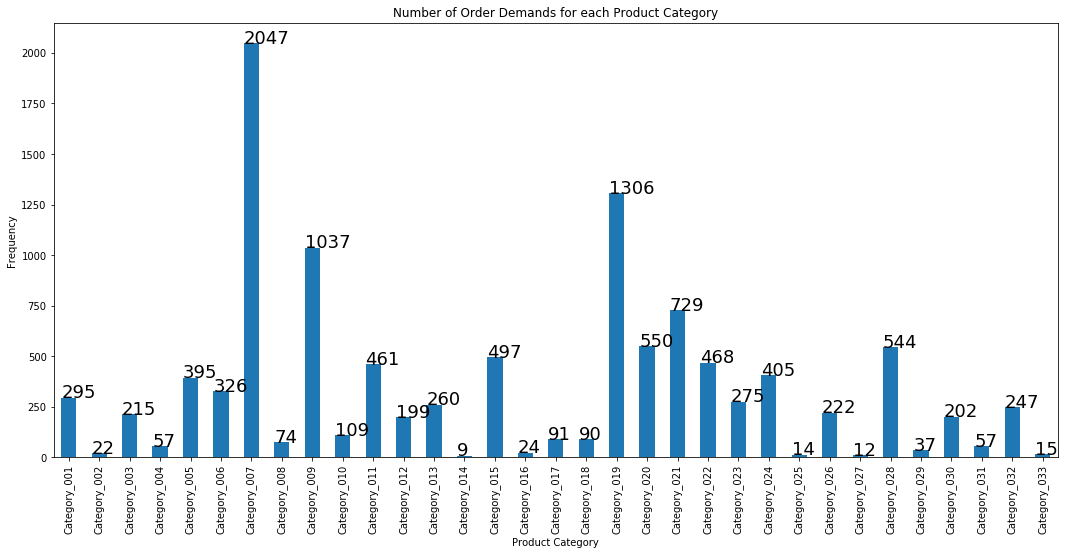

In [18]:
#Lets plot the no of products for each category
ax = df.groupby('Product_Category')['Order_Demand'].nunique().plot(kind='bar',
                                    figsize=(18,8),
                                    title="Number of Order Demands for each Product Category")

for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(i.get_height()), fontsize=18, color='black')
    
ax.set_xlabel("Product Category")
ax.set_ylabel("Frequency")

Now we plot the number of order demands for each Product_Code below. We can observe a lot of variation between the products when it comes to the order demands. 

Text(0, 0.5, 'Frequency')

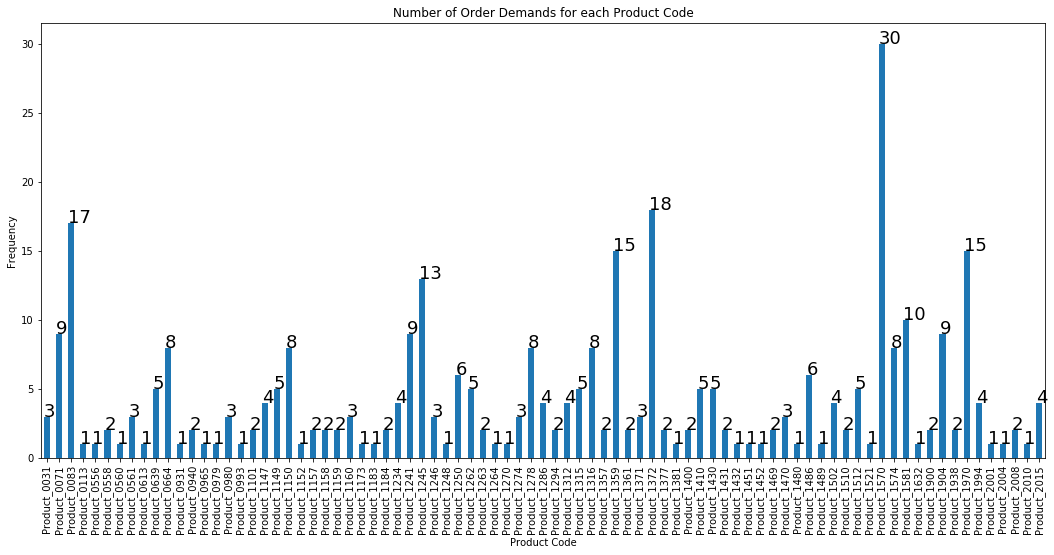

In [23]:
ax = df.head(1000).groupby('Product_Code')['Order_Demand'].nunique().plot(kind='bar',
                                    figsize=(18,8),
                                    title="Number of Order Demands for each Product Code")

for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), str(i.get_height()), fontsize=18, color='black')
    
ax.set_xlabel("Product Code")
ax.set_ylabel("Frequency")

For further analysis I will consider two products in here: Product_0620 with a total of 9428 order demands and Product_1294 with 8384 demands. Both of these products are among the top ten products when it comes to order demands. I also chose them randomly to be able to later compare forecasting for both

The "first" variable refers to Product_0620 below, while the variable "second" refers to Product_1294

In [28]:
first = df[df['Product_Code'] == 'Product_0620']

In [29]:
first.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1858,Product_0620,Whse_J,Category_001,2012/2/1,1
1861,Product_0620,Whse_J,Category_001,2012/1/20,3
1864,Product_0620,Whse_J,Category_001,2012/1/26,2
1865,Product_0620,Whse_J,Category_001,2012/2/1,4
1871,Product_0620,Whse_J,Category_001,2012/1/20,2


In [30]:
first.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,9428,9428,9428,9428,9428
unique,1,3,1,1288,112
top,Product_0620,Whse_J,Category_001,2013/12/17,1
freq,9428,8456,9428,20,4139


Drop cells that will not assist with time forecasting. In short, only leave the "Date" and "Order_Demand" columns.

In [31]:
first = first.drop(columns=["Warehouse", "Product_Code", "Product_Category"])

In [32]:
first.head()

,Date,Order_Demand
1858,2012/2/1,1
1861,2012/1/20,3
1864,2012/1/26,2
1865,2012/2/1,4
1871,2012/1/20,2


Use the .to_datetime pandas function to convert the "Date" column to a date format

In [33]:
first.loc[:, 'Date'] = pd.to_datetime(first.loc[:,'Date'], format="%Y/%m/%d")
first.describe()

,Date,Order_Demand
count,9428,9428
unique,1288,112
top,2013-12-17 00:00:00,1
freq,20,4139
first,2011-12-20 00:00:00,NaN
last,2016-12-29 00:00:00,NaN


In [34]:
first.isnull().sum()

Date            0
Order_Demand    0
dtype: int64

Convert the data frame to a datetime index below

In [35]:
first = first.set_index('Date')
first.index

DatetimeIndex(['2012-02-01', '2012-01-20', '2012-01-26', '2012-02-01',
               '2012-01-20', '2012-06-15', '2012-06-29', '2012-07-17',
               '2012-09-18', '2012-09-20',
               ...
               '2016-12-19', '2016-07-26', '2016-09-16', '2016-03-16',
               '2016-10-17', '2016-10-17', '2016-12-06', '2016-12-08',
               '2016-04-12', '2016-10-17'],
              dtype='datetime64[ns]', name='Date', length=9428, freq=None)

In [36]:
first['Order_Demand'] = first['Order_Demand'].astype(str)
first['Order_Demand'] = first['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
first['Order_Demand'] = first['Order_Demand'].astype(int)

Calculating the order demand in a per month basis starting in the first year of 2012 and ending with the the last order demand in 2016

In [37]:
first_Month = first["Order_Demand"].resample('MS').sum()
first_Month['2012':].tail(20)

Date
2015-05-01    1674
2015-06-01    2373
2015-07-01    1476
2015-08-01     634
2015-09-01    1090
2015-10-01     810
2015-11-01     943
2015-12-01     911
2016-01-01     926
2016-02-01     728
2016-03-01    1272
2016-04-01     996
2016-05-01     624
2016-06-01     876
2016-07-01     981
2016-08-01     827
2016-09-01     709
2016-10-01     993
2016-11-01    1159
2016-12-01     899
Freq: MS, Name: Order_Demand, dtype: int64

We can see that the top order demands occurred in June of 2015 and were 2373 demands. Now let's try to visualize the demand for our product throughout the months of the 5 years period (from 2012 - 2016)

In [39]:
pd.plotting.register_matplotlib_converters()

Now we plot the time series data for the first product below 

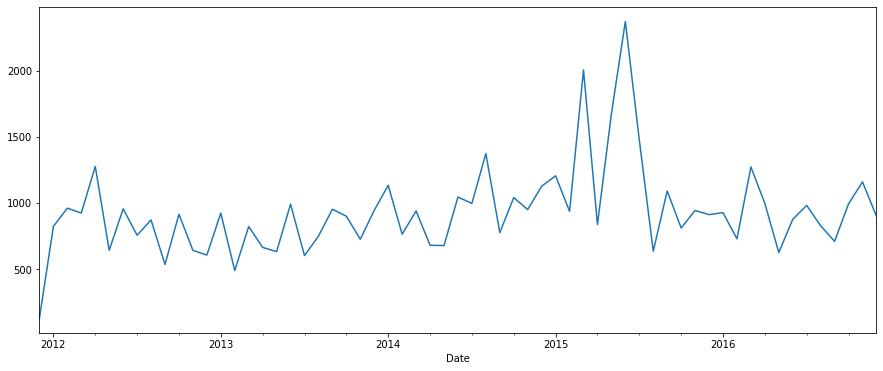

In [40]:
first_Month.plot(figsize=(15, 6))
plt.show()

Apparently, there has been fluctuations in the demand for this product throughout the years with the top two peak demands happening in 2015. Trying to experiment with a similar plot below.

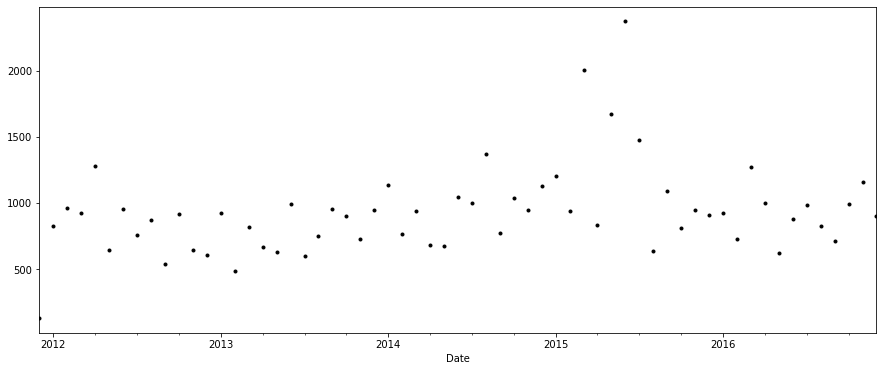

In [41]:
first_Month.plot(figsize=(15, 6), style='k.')
plt.show()

Here, I will try to use a FacebookProphet model for time series forecasting. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date. The y column must be numeric, and represents the measurement we wish to forecast.

In [42]:
first = pd.DataFrame({'Date':first_Month.index, 'Order_Demand':first_Month.values})
first.columns = ['ds', 'y']
first.head()

,ds,y
0,2011-12-01,129
1,2012-01-01,822
2,2012-02-01,960
3,2012-03-01,923
4,2012-04-01,1276


We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. 

In [43]:
m = Prophet(weekly_seasonality = True, daily_seasonality = True)
m.fit(first)

In [44]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
421,2017-11-27
422,2017-11-28
423,2017-11-29
424,2017-11-30
425,2017-12-01


The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [45]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
421,2017-11-27,478.174249,160.759828,785.428622
422,2017-11-28,724.220266,432.453677,1024.440935
423,2017-11-29,964.022132,649.780049,1260.657797
424,2017-11-30,778.855246,473.192505,1082.337620
425,2017-12-01,1054.203198,757.003064,1352.406663


# Time Series Forecasting with Facebook Prophet

We can plot the forecast by calling the Prophet.plot method and passing in our forecast dataframe

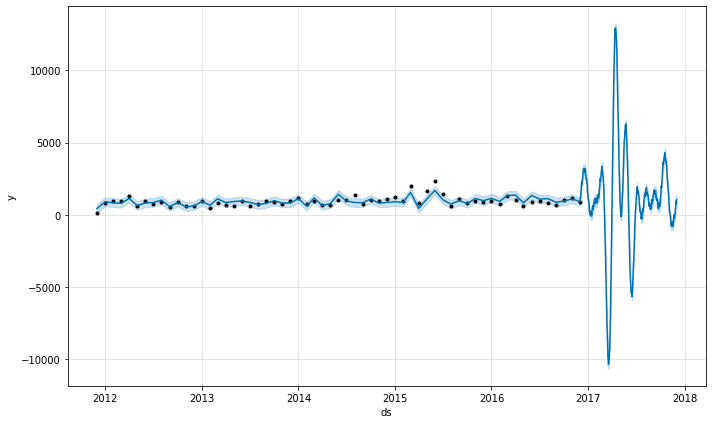

In [46]:
fig1 = m.plot(forecast)

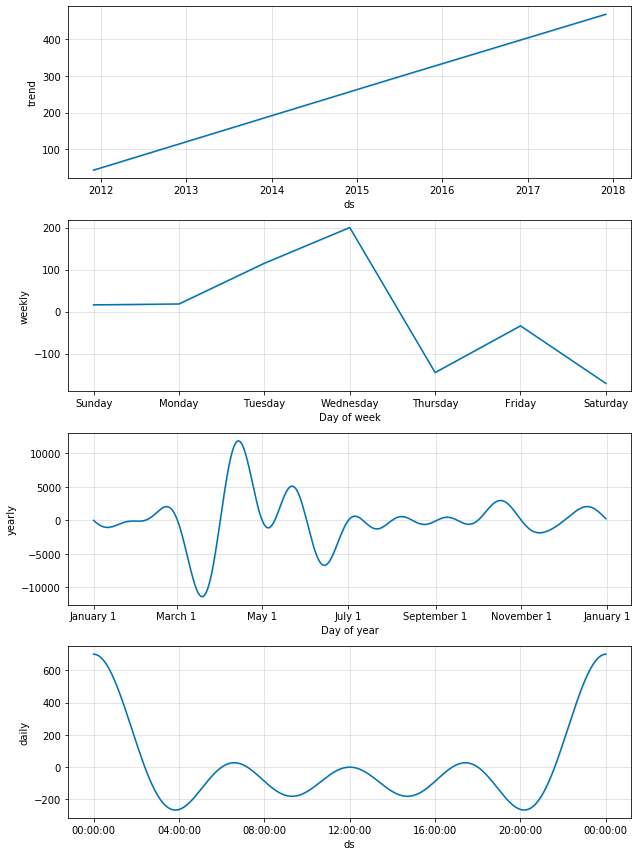

In [47]:
fig2 = m.plot_components(forecast)

Now we repeat the same process with the second product which is Product_1294

In [49]:
second = df[df['Product_Code'] =='Product_1294']

In [50]:
second.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
865,Product_1294,Whse_J,Category_019,2012/1/6,2000
873,Product_1294,Whse_J,Category_019,2012/4/5,2000
877,Product_1294,Whse_J,Category_019,2012/6/8,2000
879,Product_1294,Whse_J,Category_019,2012/7/13,1000
885,Product_1294,Whse_J,Category_019,2012/9/24,1000


In [51]:
second.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,8384,8384,8384,8384,8384
unique,1,1,1,1221,100
top,Product_1294,Whse_J,Category_019,2014/9/18,10000
freq,8384,8384,8384,21,2194


In [52]:
second = second.drop(columns=["Warehouse", "Product_Code", "Product_Category"])

In [53]:
second.head()

,Date,Order_Demand
865,2012/1/6,2000
873,2012/4/5,2000
877,2012/6/8,2000
879,2012/7/13,1000
885,2012/9/24,1000


We use the pandas.datetime function to create a date range for our data. Our date range specified below has a yearly frequency

In [54]:
second.loc[:, 'Date'] = pd.to_datetime(second.loc[:,'Date'], format="%Y/%m/%d")
second.describe()

,Date,Order_Demand
count,8384,8384
unique,1221,100
top,2014-09-18 00:00:00,10000
freq,21,2194
first,2012-01-05 00:00:00,NaN
last,2016-12-28 00:00:00,NaN


Convert the data frame to a datetime index below

In [55]:
second = second.set_index('Date')
second.index

DatetimeIndex(['2012-01-06', '2012-04-05', '2012-06-08', '2012-07-13',
               '2012-09-24', '2012-02-09', '2012-04-26', '2012-07-05',
               '2012-10-04', '2012-12-03',
               ...
               '2016-07-15', '2016-07-22', '2016-08-24', '2016-11-21',
               '2016-05-13', '2016-03-22', '2016-12-22', '2016-10-07',
               '2016-02-05', '2016-05-02'],
              dtype='datetime64[ns]', name='Date', length=8384, freq=None)

In [56]:
second['Order_Demand'] = second['Order_Demand'].astype(str)
second['Order_Demand'] = second['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
second['Order_Demand'] = second['Order_Demand'].astype(int)

In [57]:
second_Month = second["Order_Demand"].resample('MS').sum()
second_Month['2012':].tail(20)

Date
2015-05-01    1106700
2015-06-01    1342100
2015-07-01    2310900
2015-08-01    1042200
2015-09-01    1160100
2015-10-01    1138800
2015-11-01    1440300
2015-12-01    1297300
2016-01-01    1084300
2016-02-01    1186200
2016-03-01    1482100
2016-04-01    1336900
2016-05-01     942000
2016-06-01    1255200
2016-07-01    1497700
2016-08-01    1162500
2016-09-01    1453800
2016-10-01    1200100
2016-11-01    1355000
2016-12-01    1659900
Freq: MS, Name: Order_Demand, dtype: int64

In [217]:
pd.plotting.register_matplotlib_converters()

Now we plot the time series data for our second product below

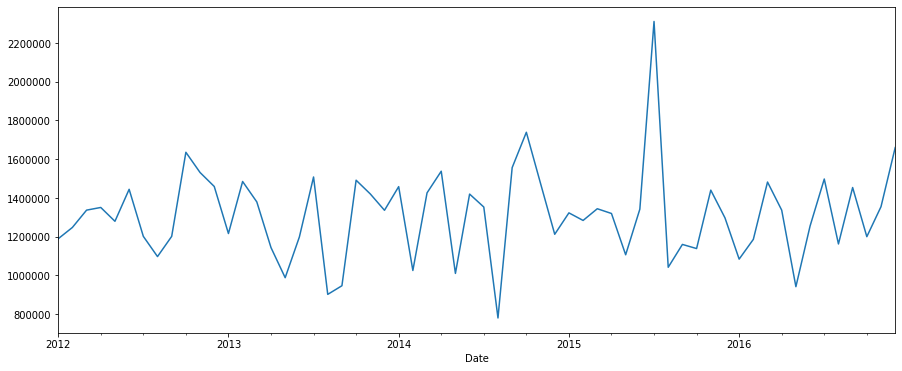

In [58]:
#Visualizing Demand Time Series Data
second_Month.plot(figsize=(15, 6))
plt.show()

From the figure above, we notice that most demands of Product_1294 peaks in the year 2015 while it plummets downwards in the year 2014

Just like above, we develop a Facebook Prophet model for forecasting.  

In [59]:
second = pd.DataFrame({'Date':second_Month.index, 'Order_Demand':second_Month.values})
second.columns = ['ds', 'y']
second.head()

,ds,y
0,2012-01-01,1189400
1,2012-02-01,1247700
2,2012-03-01,1337100
3,2012-04-01,1350900
4,2012-05-01,1279500


In [60]:
#fitting the model
model = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
model.fit(second)

In [61]:
#making future model for 365 days ie dor 2017-18
fut = model.make_future_dataframe(periods=365)
fut.tail()

,ds
420,2017-11-27
421,2017-11-28
422,2017-11-29
423,2017-11-30
424,2017-12-01


In [62]:
#predicting the future model
forecast = model.predict(fut)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-11-27,1.781375e+05,-1.064574e+05,4.607269e+05
421,2017-11-28,5.102325e+05,2.317182e+05,7.626725e+05
422,2017-11-29,9.400640e+05,6.482534e+05,1.221397e+06
423,2017-11-30,1.145173e+06,8.593050e+05,1.415369e+06
424,2017-12-01,1.432199e+06,1.153405e+06,1.713463e+06


<Figure size 1296x432 with 0 Axes>

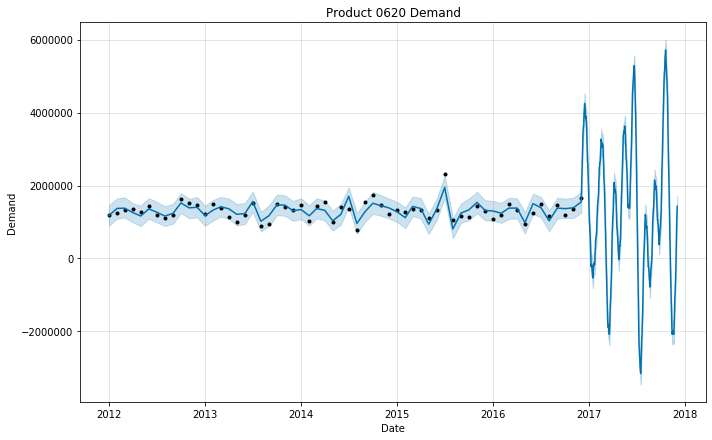

In [63]:
#plotting the demand graph on basis of the model
plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Demand')
plt.title('Product 0620 Demand');

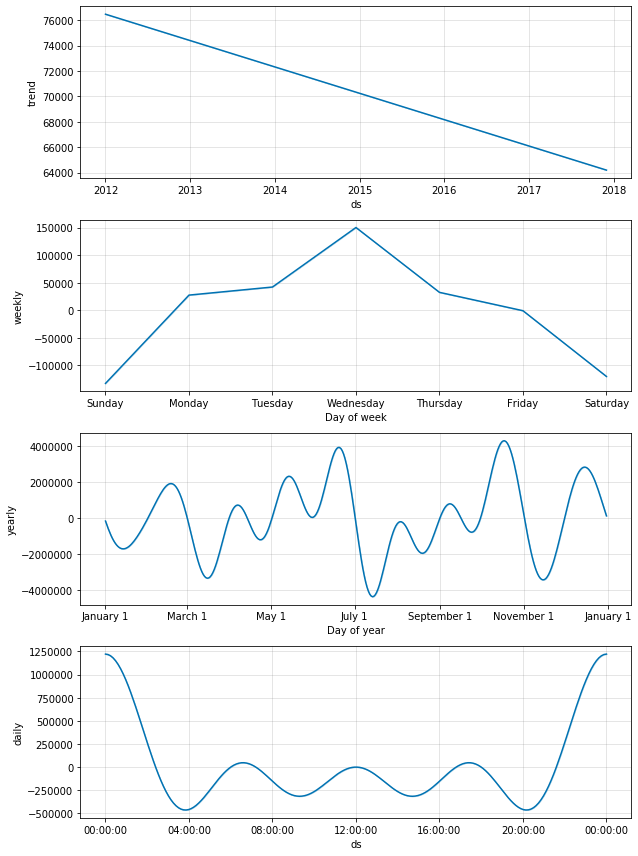

In [64]:
#componenets analysis
figg = model.plot_components(forecast)

# Time Series Forecasting with ARIMA

Below, I developed an ARIMA model for time series forecasting for both products: Product_1294 and Product_0620

ARIMA models are denoted with the notation ARIMA(p,d,q). These three parameters represent seasonality, noise and trend in the data

In [167]:
fp = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our Order Demand ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [168]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(first_Month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1001.0171114095491
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:771.799001391282
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:731.7074970465659
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:542.6916515405198
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:746.9664772681742
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:715.1712715779462
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:560.5000345050985
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:544.1443347418659
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:940.7975128643568
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:735.7446370266443
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:712.9976162645274
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:525.3495229928154
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:740.4675628603285
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:699.1991608174858
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:553.0574967807346
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:524.8953007181045
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:875.8202566668034
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:703.6748620479538
ARIMA(0, 1

Choosing the SARIMAX that yields the lowest AIC value: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:523.0967879680796

In [169]:
mod = sm.tsa.statespace.SARIMAX(first_Month,order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4469      0.240      1.858      0.063      -0.024       0.918
ma.L1         -0.8929      0.144     -6.186      0.000      -1.176      -0.610
ar.S.L12      -0.7909      0.165     -4.800      0.000      -1.114      -0.468
sigma2       1.42e+05   3.41e+04      4.159      0.000    7.51e+04    2.09e+05


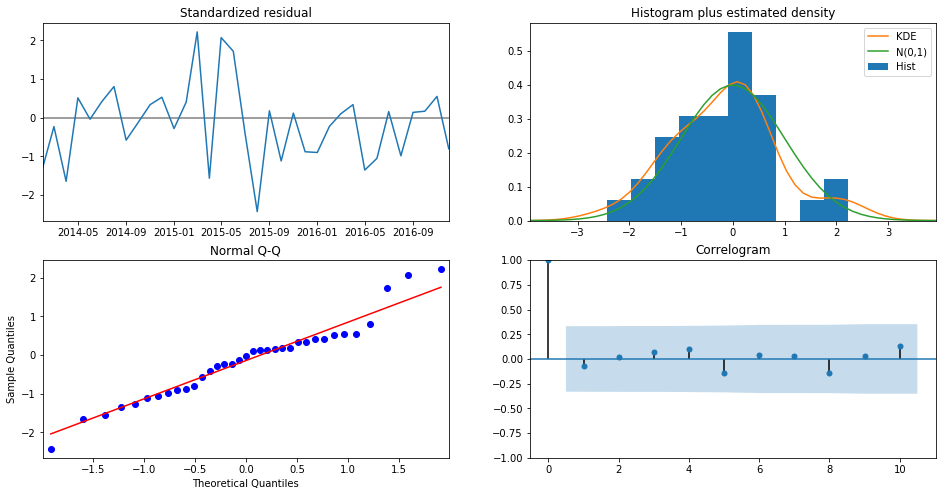

In [170]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

This step is parameter Selection for our Order Demand ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [176]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(second_Month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1833.7735609287588
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1434.9557244880243
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1321.4800681315744
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2996.3831901329117
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1348.172584758702
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1322.89188732645
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:999.4067576195843
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2975.064700604475
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1767.9781885187176
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1396.4575805718382
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1293.750644417102
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2917.6365707616515
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1450.3180915055068
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1391.8671832241387
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1003.9751138784831
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2929.7551215533267
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1646.1003598445047
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1311.431195566086

Choosing the SARIMAX that yields the lowest AIC value which is: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:958.1826685577364

In [177]:
mod = sm.tsa.statespace.SARIMAX(second_Month,order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0858      0.537      0.160      0.873      -0.966       1.138
ma.L1         -0.7843      0.267     -2.938      0.003      -1.308      -0.261
ar.S.L12      -0.5725      0.319     -1.795      0.073      -1.198       0.053
sigma2      1.203e+11   1.61e-12   7.45e+22      0.000     1.2e+11     1.2e+11


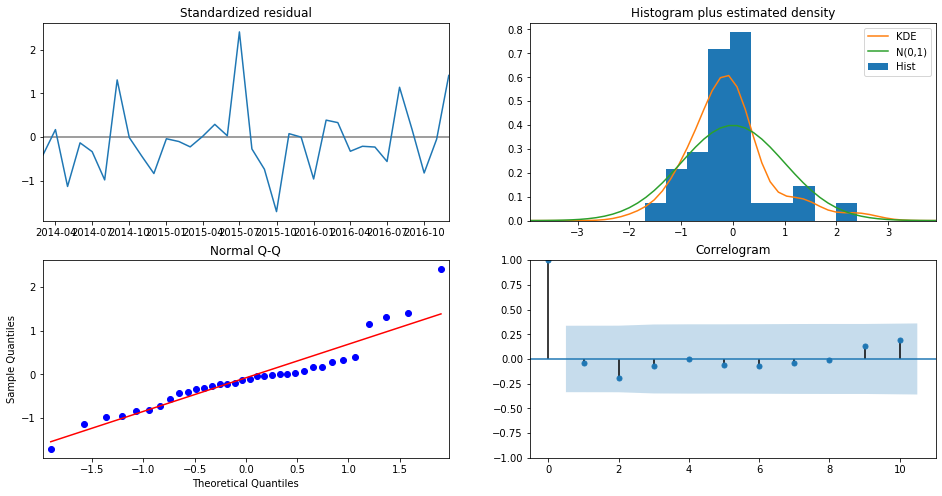

In [178]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Observations

We applied Facebook Prophet forecasting model to two products: Product_1294 and Product_0620. For Product_1294 an expected increase in demand is expected between 2016 and 2018. An increase of more than a 100 in order demand in these two years. To the contrary, for Product_0620 there is a significant decrease in the order demand between 2016 and 2018 and that which amounts to a 2000 decline in order demand per year.

Both products tend to peak on a Wednesday but a yearly trend on peaking in May for Product_1294 and in July for Product_0620

We can also observe that the ARIMA model for each product displays similar trends in seasonality and future predictions.